<a href="https://colab.research.google.com/github/mohameddhameem/LearnPyTorch/blob/master/NLP_Basics_with_PyTorch_NLTK_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basics of NLP with PyTorch

# Overview


- <a href="#section-3-0">**3.0. Data Preparation**</a>
  - <a href="#section-3-0-1">3.0.1. *Vocabulary*</a>
    - <a href="#section-3-0-1-a"> Pet Peeve: using `gensim`</a>
  - <a href="#section-3-0-2">3.0.2. *Dataset*</a>  (<a href="#section-3-0-2-hints">Hints</a>)
    - <a href="#section-3-0-2-return-dict">Return `dict` in `__getitem__()`</a>
    - <a href="#section-3-0-2-labeleddata">Try `LabeledDataset`</a>
<br><br>
- <a href="#section-3-1">**3.1. Word2Vec from Scratch**</a>
  - <a href="#section-3-1-1">3.1.1. *CBOW*</a>
  - <a href="#section-3-1-2">3.1.2. *Skipgram*</a>
  - <a href="#section-3-1-3">3.1.3. *Word2Vec Dataset*</a> (<a href="#section-3-1-3-hint">Hints</a>)
  - <a href="#section-3-1-4-hint">3.1.4. *Train a CBOW model*</a>
    - <a href="#section-3-1-4-fill-cbow">The CBOW model</a>
    - <a href="#section-3-1-4-train-cbow">Train the model (*for real*)</a>
    - <a href="#section-3-1-4-evaluate-cbow">Evaluate the model</a>
    - <a href="#section-3-1-4-load-model">Load model at specific epoch</a>
  - <a href="#section-3-1-5">3.1.5. *Train a Skipgram model*</a>
    - <a href="#section-3-1-5-forward">Take a closer look at `forward()`</a>
    - <a href="#section-3-1-5-train">Train the model (*for real*)</a>
    - <a href="section-3-1-5-evaluate">Evaluate the model</a>
  - <a href="#section-3-1-6">3.1.6. *Loading Pre-trained Embeddings*</a>
    - <a href="#section-3-1-6-vocab">Override the Embedding vocabulary</a>
    - <a href="#section-3-1-6-pretrained">Override the Embedding weights</a>
    - <a href="#section-3-1-6-eval-skipgram">Evaluate on the Skipgram task</a>
    - <a href="#section-3-1-6-eval-cbow">Evaluate on the CBOW task</a>
    - <a href="#section-3-1-6-unfreeze-finetune">Unfreeeze and finetune</a>
    - <a href="#section-3-1-6-reval-cbow">Re-evaluate on the CBOW task</a>
<br><br>

<a id="section-3-0"></a>
# 3.0. Data Preparation

Before we train our own embeddings, lets first understand how to read text data into pytorch.
The native pytorch way to load datasets is to use the `torch.utils.data.Dataset` object.

There are already several other libraries that help with loading text datasets, e.g. 

 - FastAI https://docs.fast.ai/text.data.html
 - AllenNLP https://allenai.github.io/allennlp-docs/api/allennlp.data.dataset.html
 - Torch Text https://github.com/pytorch/text#data
 - Texar https://texar.readthedocs.io/en/latest/code/data.html#id4 
 - SpaCy https://github.com/explosion/thinc
 

But to truly understand and use it for the custom datasets you'll see at work, lets learn it the native way.

<a id="section-3-0-1"></a>
## 3.0.1  Vocabulary

Given a text, the first thing to do is to build a vocabulary (i.e. a dictionary of unique words) and assign an index to each unique word.

In [4]:
!pip install sklearn torch tqdm nltk lazyme ansi requests gensim tsundoku
!python -m nltk.downloader movie_reviews punkt
from IPython.display import display, Markdown, Latex
from tsundoku.word2vec_hints import *

  Created wheel for lazyme: filename=lazyme-0.0.23-py3-none-any.whl size=7929 sha256=7395af905717442e6189cc3adc04d20a2232c7af94a4fa927242d16b841bf0c6
  Stored in directory: /root/.cache/pip/wheels/5c/14/dc/ad5e41a497bf8aa3434c727cd8b0a0e67876eae94fb3130724
  Created wheel for ansi: filename=ansi-0.1.3-py3-none-any.whl size=6825 sha256=078fd70d05949f05ebbd32a495acb0f98a65059d504b0ddeca1f198d711138b4
  Stored in directory: /root/.cache/pip/wheels/35/fd/65/a952ef68e49306861529325cbe318acac0642a673487d36a64
  Created wheel for tsundoku: filename=tsundoku-0.0.6-py3-none-any.whl size=4872 sha256=13ef14e1aadcb7b837e2be8c952d06492a771662a0faea3fe09da01e926c04f3
  Stored in directory: /root/.cache/pip/wheels/13/d1/e8/20a3112b49141d5fc3981578e0bffb6b17c57b44786fbbacc2
Successfully built lazyme ansi tsundoku
/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredi

In [0]:
import random
from itertools import chain

from tqdm import tqdm
from gensim.corpora import Dictionary

import torch
from torch import nn, optim, tensor, autograd
from torch.nn import functional as F
from torch.utils.data import Dataset
import numpy as np

from functools import partial
from torch.utils.data import Dataset, DataLoader
from torch import functional as F

In [6]:
try: # Use the default NLTK tokenizer.
    from nltk import word_tokenize, sent_tokenize 
    # Testing whether it works. 
    # Sometimes it doesn't work on some machines because of setup issues.
    word_tokenize(sent_tokenize("This is a foobar sentence. Yes it is.")[0])
    print('It Works')
except: # Use a naive sentence tokenizer and toktok.
    import re
    from nltk.tokenize import ToktokTokenizer
    # See https://stackoverflow.com/a/25736515/610569
    sent_tokenize = lambda x: re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', x)
    # Use the toktok tokenizer that requires no dependencies.
    toktok = ToktokTokenizer()
    word_tokenize = word_tokenize = toktok.tokenize
    print('It Still Works')

It Works


In [0]:
text = """Language users never choose words randomly, and language is essentially
non-random. Statistical hypothesis testing uses a null hypothesis, which
posits randomness. Hence, when we look at linguistic phenomena in corpora, 
the null hypothesis will never be true. Moreover, where there is enough
data, we shall (almost) always be able to establish that it is not true. In
corpus studies, we frequently do have enough data, so the fact that a relation 
between two phenomena is demonstrably non-random, does not support the inference 
that it is not arbitrary. We present experimental evidence
of how arbitrary associations between word frequencies and corpora are
systematically non-random. We review literature in which hypothesis testing 
has been used, and show how it has often led to unhelpful or misleading results.""".lower()

tokenized_text = [word_tokenize(sent) for sent in sent_tokenize(text)]

uniq_tokens = set(chain(*tokenized_text))

vocab = {}   # Assign indices to every word.
idx2tok = {} # Also keep an dict of index to words.
for i, token in enumerate(uniq_tokens):
    vocab[token] = i
    idx2tok[i] = token

In [8]:
vocab

{'(': 33,
 ')': 79,
 ',': 52,
 '.': 49,
 'a': 2,
 'able': 5,
 'almost': 39,
 'always': 16,
 'and': 48,
 'arbitrary': 64,
 'are': 71,
 'associations': 31,
 'at': 70,
 'be': 34,
 'been': 17,
 'between': 13,
 'choose': 41,
 'corpora': 44,
 'corpus': 69,
 'data': 4,
 'demonstrably': 1,
 'do': 12,
 'does': 54,
 'enough': 55,
 'essentially': 56,
 'establish': 80,
 'evidence': 30,
 'experimental': 72,
 'fact': 28,
 'frequencies': 47,
 'frequently': 81,
 'has': 15,
 'have': 45,
 'hence': 61,
 'how': 25,
 'hypothesis': 51,
 'in': 75,
 'inference': 11,
 'is': 68,
 'it': 46,
 'language': 43,
 'led': 29,
 'linguistic': 73,
 'literature': 26,
 'look': 58,
 'misleading': 10,
 'moreover': 50,
 'never': 60,
 'non-random': 14,
 'not': 27,
 'null': 59,
 'of': 84,
 'often': 7,
 'or': 8,
 'phenomena': 85,
 'posits': 76,
 'present': 38,
 'randomly': 63,
 'randomness': 0,
 'relation': 86,
 'results': 67,
 'review': 57,
 'shall': 62,
 'show': 77,
 'so': 6,
 'statistical': 32,
 'studies': 22,
 'support': 82,


In [9]:
# Retrieve the index of the word 'corpora'
vocab['corpora']

44

In [10]:
# The indexed representation of the first sentence.

sent0 = tokenized_text[0]
print('sent0', sent0)
[vocab[token] for token in sent0] 

sent0 ['language', 'users', 'never', 'choose', 'words', 'randomly', ',', 'and', 'language', 'is', 'essentially', 'non-random', '.']


[43, 21, 60, 41, 83, 63, 52, 48, 43, 68, 56, 14, 49]

<a id="section-3-0-1-a"></a>

### Pet Peeve (Gensim)

`gensim` has functions that are optimized for such operations. In fact, I've written a [whole preprocessing pipeline library for me to use for language modelling and machine translation purposes](https://github.com/alvations/komorebi/blob/master/komorebi/text.py) =)

Using `gensim`, I would have written the above as such:

In [0]:
from gensim.corpora.dictionary import Dictionary
vocab = Dictionary(tokenized_text)

In [12]:
# Note the key-value order is different of gensim from the native Python's
dict(vocab.items())

{0: ',',
 1: '.',
 2: 'and',
 3: 'choose',
 4: 'essentially',
 5: 'is',
 6: 'language',
 7: 'never',
 8: 'non-random',
 9: 'randomly',
 10: 'users',
 11: 'words',
 12: 'a',
 13: 'hypothesis',
 14: 'null',
 15: 'posits',
 16: 'randomness',
 17: 'statistical',
 18: 'testing',
 19: 'uses',
 20: 'which',
 21: 'at',
 22: 'be',
 23: 'corpora',
 24: 'hence',
 25: 'in',
 26: 'linguistic',
 27: 'look',
 28: 'phenomena',
 29: 'the',
 30: 'true',
 31: 'we',
 32: 'when',
 33: 'will',
 34: '(',
 35: ')',
 36: 'able',
 37: 'almost',
 38: 'always',
 39: 'data',
 40: 'enough',
 41: 'establish',
 42: 'it',
 43: 'moreover',
 44: 'not',
 45: 'shall',
 46: 'that',
 47: 'there',
 48: 'to',
 49: 'where',
 50: 'arbitrary',
 51: 'between',
 52: 'corpus',
 53: 'demonstrably',
 54: 'do',
 55: 'does',
 56: 'fact',
 57: 'frequently',
 58: 'have',
 59: 'inference',
 60: 'relation',
 61: 'so',
 62: 'studies',
 63: 'support',
 64: 'two',
 65: 'are',
 66: 'associations',
 67: 'evidence',
 68: 'experimental',
 69: 'fr

In [13]:
vocab.token2id['corpora']

23

In [14]:
vocab.doc2idx(sent0)

[6, 10, 7, 3, 11, 9, 0, 2, 6, 5, 4, 8, 1]

The "indexed form" of the tokens in the sentence forms the ***vectorized*** input to the `nn.Embedding` layer in PyTorch.

<a id="section-3-0-2"></a>

# 3.0.2 Dataset

Lets try creating a `torch.utils.data.Dataset` object.

In [0]:
from torch.utils.data import Dataset, DataLoader

class Text(Dataset):
    def __init__(self, tokenized_texts):
        """
        :param tokenized_texts: Tokenized text.
        :type tokenized_texts: list(list(str))
        """
        self.sents = tokenized_texts
        self.vocab = Dictionary(tokenized_texts)

    def __getitem__(self, index):
        """
        The primary entry point for PyTorch datasets.
        This is were you access the specific data row you want.
        
        :param index: Index to the data point.
        :type index: int
        """
        # Hint: You want to return a vectorized sentence here.
        return {'x': self.vectorize(self.sents[index])}

    def vectorize(self, tokens):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        return self.vocab.doc2idx(tokens)
    
    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]

In [0]:
### BELOE IS FROM MY LECTURER. FEEL FREE TO TRY
# Option 1: To see the hint and partial code for the cell above, uncomment the following line.
##hint_dataset_vectorize()
##code_text_dataset_vectorize()

# Option 2: "I give up just, run the code for me" 
# Uncomment the next two lines, if you really gave up... 
#full_code_text_dataset_vectorize()
#from tsundoku.word2vec import Text


In [16]:
tokenized_text[5]

['we',
 'present',
 'experimental',
 'evidence',
 'of',
 'how',
 'arbitrary',
 'associations',
 'between',
 'word',
 'frequencies',
 'and',
 'corpora',
 'are',
 'systematically',
 'non-random',
 '.']

In [17]:
text_dataset = Text(tokenized_text)
text_dataset[5] # First sentence. Representation of above text

{'x': [31, 72, 68, 67, 71, 70, 50, 66, 51, 74, 69, 2, 23, 65, 73, 8, 1]}

<a id="section-3-0-2-return-dict"></a>

### Return `dict` in `__getitem__()`

This is nice if we're just representing sentences/documents by their indices but when we're doing machine learning, we usually have `X` and `Y`. 

If we have labels for the each sentence, we can also put it into to `__getitem__()` by having it return a dictionary.

In [0]:
from torch.utils.data import Dataset, DataLoader

class LabeledText(Dataset):
    def __init__(self, tokenized_texts, labels):
        """
        :param tokenized_texts: Tokenized text.
        :type tokenized_texts: list(list(str))
        """
        self.sents = tokenized_texts
        self.labels = labels # Sentence level labels.
        self.vocab = Dictionary(self.sents)

    def __getitem__(self, index):
        """
        The primary entry point for PyTorch datasets.
        This is were you access the specific data row you want.
        
        :param index: Index to the data point.
        :type index: int
        """
        return {'x': self.vectorize(self.sents[index]), 'y': self.labels[index]}

    def vectorize(self, tokens):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        return self.vocab.doc2idx(tokens)
    
    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]

<a id="section-3-0-2-labeleddata"></a>

### Lets try the `LabeledDataset` on a movie review corpus

In [19]:
from nltk.corpus import movie_reviews
documents = []
labels = []

for fileid in tqdm(movie_reviews.fileids()):
    label = fileid.split('/')[0]
    doc = word_tokenize(movie_reviews.open(fileid).read())
    documents.append(doc)
    labels.append(label)

100%|██████████| 2000/2000 [00:09<00:00, 220.75it/s]


In [20]:
print(documents[0])

['plot', ':', 'two', 'teen', 'couples', 'go', 'to', 'a', 'church', 'party', ',', 'drink', 'and', 'then', 'drive', '.', 'they', 'get', 'into', 'an', 'accident', '.', 'one', 'of', 'the', 'guys', 'dies', ',', 'but', 'his', 'girlfriend', 'continues', 'to', 'see', 'him', 'in', 'her', 'life', ',', 'and', 'has', 'nightmares', '.', 'what', "'s", 'the', 'deal', '?', 'watch', 'the', 'movie', 'and', '``', 'sorta', '``', 'find', 'out', '.', '.', '.', 'critique', ':', 'a', 'mind-fuck', 'movie', 'for', 'the', 'teen', 'generation', 'that', 'touches', 'on', 'a', 'very', 'cool', 'idea', ',', 'but', 'presents', 'it', 'in', 'a', 'very', 'bad', 'package', '.', 'which', 'is', 'what', 'makes', 'this', 'review', 'an', 'even', 'harder', 'one', 'to', 'write', ',', 'since', 'i', 'generally', 'applaud', 'films', 'which', 'attempt', 'to', 'break', 'the', 'mold', ',', 'mess', 'with', 'your', 'head', 'and', 'such', '(', 'lost', 'highway', '&', 'memento', ')', ',', 'but', 'there', 'are', 'good', 'and', 'bad', 'ways'

In [21]:
labeled_dataset = LabeledText(documents, labels)
print(labeled_dataset[0])  # First review in the data.

{'x': [243, 17, 314, 294, 77, 140, 307, 20, 68, 237, 6, 97, 34, 299, 98, 8, 302, 135, 167, 33, 22, 8, 226, 220, 297, 145, 87, 6, 60, 158, 136, 74, 307, 262, 157, 165, 153, 179, 6, 34, 149, 214, 8, 333, 2, 297, 82, 18, 326, 297, 204, 34, 19, 280, 19, 124, 230, 8, 8, 8, 79, 17, 20, 199, 204, 129, 297, 294, 133, 296, 311, 225, 20, 322, 75, 164, 6, 60, 245, 169, 165, 20, 322, 46, 234, 8, 337, 168, 333, 188, 304, 253, 33, 108, 148, 226, 307, 345, 6, 272, 163, 132, 37, 122, 337, 42, 307, 59, 297, 201, 6, 196, 341, 348, 152, 34, 290, 4, 185, 156, 1, 195, 5, 6, 60, 300, 38, 142, 34, 46, 328, 220, 189, 28, 315, 220, 122, 6, 34, 301, 128, 173, 86, 208, 276, 304, 226, 76, 8, 302, 263, 307, 150, 293, 304, 246, 209, 72, 6, 60, 113, 169, 295, 8, 277, 333, 38, 297, 248, 341, 297, 204, 18, 331, 6, 170, 186, 247, 168, 296, 169, 2, 271, 309, 172, 8, 169, 282, 221, 19, 216, 19, 60, 299, 95, 167, 304, 19, 116, 19, 342, 165, 337, 347, 6, 40, 33, 43, 194, 6, 150, 215, 164, 333, 2, 141, 225, 8, 300, 38, 96, 

In [22]:
print(labeled_dataset[0]['x'])  # First review in vectorized index format.

[243, 17, 314, 294, 77, 140, 307, 20, 68, 237, 6, 97, 34, 299, 98, 8, 302, 135, 167, 33, 22, 8, 226, 220, 297, 145, 87, 6, 60, 158, 136, 74, 307, 262, 157, 165, 153, 179, 6, 34, 149, 214, 8, 333, 2, 297, 82, 18, 326, 297, 204, 34, 19, 280, 19, 124, 230, 8, 8, 8, 79, 17, 20, 199, 204, 129, 297, 294, 133, 296, 311, 225, 20, 322, 75, 164, 6, 60, 245, 169, 165, 20, 322, 46, 234, 8, 337, 168, 333, 188, 304, 253, 33, 108, 148, 226, 307, 345, 6, 272, 163, 132, 37, 122, 337, 42, 307, 59, 297, 201, 6, 196, 341, 348, 152, 34, 290, 4, 185, 156, 1, 195, 5, 6, 60, 300, 38, 142, 34, 46, 328, 220, 189, 28, 315, 220, 122, 6, 34, 301, 128, 173, 86, 208, 276, 304, 226, 76, 8, 302, 263, 307, 150, 293, 304, 246, 209, 72, 6, 60, 113, 169, 295, 8, 277, 333, 38, 297, 248, 341, 297, 204, 18, 331, 6, 170, 186, 247, 168, 296, 169, 2, 271, 309, 172, 8, 169, 282, 221, 19, 216, 19, 60, 299, 95, 167, 304, 19, 116, 19, 342, 165, 337, 347, 6, 40, 33, 43, 194, 6, 150, 215, 164, 333, 2, 141, 225, 8, 300, 38, 96, 6, 300

In [23]:
print(labeled_dataset[0]['y'])  # Label of the first review in the data. 

neg


<a id="section-3-1"></a>

# 3.1 Word2Vec Training

Word2Vec has two training variants:

 - **Continuous Bag of Words (CBOW)**: Predict center word from (bag of) context words.
 - **Skip-grams**: Predict context words given center word.
  
Visually, they look like this:



<img src="https://lilianweng.github.io/lil-log/assets/images/word2vec-cbow.png" width="500" align="left">

Fig. 1. The skip-gram model. Both the input vector xx and the output yy are one-hot encoded word representations. <br>The hidden layer is the word embedding of size NN.

<img src="https://lilianweng.github.io/lil-log/assets/images/word2vec-skip-gram.png" width="500" align="left">

Fig. 2. The CBOW model. Word vectors of multiple context words are averaged to get a fixed-length vector as in the hidden layer. Other symbols have the same meanings as in Fig 1.

(Pretty network images above are from [https://lilianweng.github.io](https://lilianweng.github.io/lil-log/2017/10/15/learning-word-embedding.html#context-based-continuous-bag-of-words-cbow))

<a id="section-3-1-1"></a>

## 3.1.1. CBOW

CBOW windows through the sentence and picks out the center word as the `Y` and the surrounding context words as the inputs `X`. 


In [24]:
from lazyme import per_window, per_chunk

xx =[1,2,3,4]
list(per_window(xx, n=2))
list(per_chunk(xx, n=3))

[(1, 2, 3), (4, None, None)]

In [0]:
def per_window(sequence, n=1):
    """
    From http://stackoverflow.com/q/42220614/610569
        >>> list(per_window([1,2,3,4], n=2))
        [(1, 2), (2, 3), (3, 4)]
        >>> list(per_window([1,2,3,4], n=3))
        [(1, 2, 3), (2, 3, 4)]
    """
    start, stop = 0, n
    seq = list(sequence)
    while stop <= len(seq):
        yield seq[start:stop]
        start += 1
        stop += 1

def cbow_iterator(tokens, window_size):
    n = window_size * 2 + 1
    for window in per_window(tokens, n):
        target = window.pop(window_size)
        yield window, target   # X = window ; Y = target. 


In [0]:
sent0 = ['language', 'users', 'never', 'choose', 'words', 'randomly', ',', 
         'and', 'language', 'is', 'essentially', 'non-random', '.']

In [27]:
list(cbow_iterator(sent0, 2)) 
#the first part is X and target is Y
#X => 'language', 'users', 'choose', 'words'
#y => 'never'

[(['language', 'users', 'choose', 'words'], 'never'),
 (['users', 'never', 'words', 'randomly'], 'choose'),
 (['never', 'choose', 'randomly', ','], 'words'),
 (['choose', 'words', ',', 'and'], 'randomly'),
 (['words', 'randomly', 'and', 'language'], ','),
 (['randomly', ',', 'language', 'is'], 'and'),
 ([',', 'and', 'is', 'essentially'], 'language'),
 (['and', 'language', 'essentially', 'non-random'], 'is'),
 (['language', 'is', 'non-random', '.'], 'essentially')]

In [28]:
list(cbow_iterator(sent0, 3)) 

[(['language', 'users', 'never', 'words', 'randomly', ','], 'choose'),
 (['users', 'never', 'choose', 'randomly', ',', 'and'], 'words'),
 (['never', 'choose', 'words', ',', 'and', 'language'], 'randomly'),
 (['choose', 'words', 'randomly', 'and', 'language', 'is'], ','),
 (['words', 'randomly', ',', 'language', 'is', 'essentially'], 'and'),
 (['randomly', ',', 'and', 'is', 'essentially', 'non-random'], 'language'),
 ([',', 'and', 'language', 'essentially', 'non-random', '.'], 'is')]

<a id="section-3-1-2"></a>

## 3.1.2. Skipgram

In [0]:
def skipgram_iterator(tokens, window_size):
    n = window_size * 2 + 1 
    for i, window in enumerate(per_window(tokens, n)):
        target = window.pop(window_size)
        # Generate positive samples.
        for context_word in window:
            yield target, context_word, 1
        # Generate negative samples.
        for _ in range(n-1):
            leftovers = tokens[:i] + tokens[i+n:]
            yield target, random.choice(leftovers), 0

In [30]:
list(skipgram_iterator(sent0, 2))
#1 is positive sample and 0 negative

[('never', 'language', 1),
 ('never', 'users', 1),
 ('never', 'choose', 1),
 ('never', 'words', 1),
 ('never', '.', 0),
 ('never', '.', 0),
 ('never', 'essentially', 0),
 ('never', 'and', 0),
 ('choose', 'users', 1),
 ('choose', 'never', 1),
 ('choose', 'words', 1),
 ('choose', 'randomly', 1),
 ('choose', '.', 0),
 ('choose', 'and', 0),
 ('choose', 'language', 0),
 ('choose', 'non-random', 0),
 ('words', 'never', 1),
 ('words', 'choose', 1),
 ('words', 'randomly', 1),
 ('words', ',', 1),
 ('words', 'users', 0),
 ('words', 'non-random', 0),
 ('words', 'users', 0),
 ('words', 'non-random', 0),
 ('randomly', 'choose', 1),
 ('randomly', 'words', 1),
 ('randomly', ',', 1),
 ('randomly', 'and', 1),
 ('randomly', 'language', 0),
 ('randomly', 'language', 0),
 ('randomly', 'never', 0),
 ('randomly', 'users', 0),
 (',', 'words', 1),
 (',', 'randomly', 1),
 (',', 'and', 1),
 (',', 'language', 1),
 (',', 'users', 0),
 (',', 'choose', 0),
 (',', 'choose', 0),
 (',', 'never', 0),
 ('and', 'randomly

## Cut-away: What is `partial`?

The [`functools.partial`](https://docs.python.org/3.7/library/functools.html#functools.partial) function in Python is a mechanism to overload a function with preset arguments. 

For example:

In [31]:
from nltk import ngrams

# Generates bigrams
list(ngrams('this is a sentence'.split(), n=2))

[('this', 'is'), ('is', 'a'), ('a', 'sentence')]

In [0]:
from functools import partial

# You can create a new function that "preset" the `n` argument, e.g.
bigrams = partial(ngrams, n=2)
trigrams = partial(ngrams, n=3)

In [33]:
list(trigrams('this is a sentence'.split()))

[('this', 'is', 'a'), ('is', 'a', 'sentence')]

In [34]:
list(bigrams('this is a sentence'.split()))

[('this', 'is'), ('is', 'a'), ('a', 'sentence')]

<a id="section-3-1-3"></a>

## 3.1.3 Word2Vec Dataset

Now that we know what are the inputs `X` and outputs `Y` of the Word2Vec task. 

Lets put everything together and modify the `Dataset` so that `__getitem__` retrieves CBOW or Skipgram formats.

In [0]:
class Word2VecText(Dataset):
    def __init__(self, tokenized_texts, window_size, variant):
        """
        :param tokenized_texts: Tokenized text.
        :type tokenized_texts: list(list(str))
        """
        self.sents = tokenized_texts
        self._len = len(self.sents)
        self.vocab = Dictionary(self.sents)
        self.window_size = window_size
        self.variant = variant
        if variant.lower() == 'cbow':
            self._iterator = partial(self.cbow_iterator, window_size=self.window_size)
        elif variant.lower() == 'skipgram':
            self._iterator = partial(self.skipgram_iterator, window_size=self.window_size)

    def __getitem__(self, index):
        """
        The primary entry point for PyTorch datasets.
        This is were you access the specific data row you want.

        :param index: Index to the data point.
        :type index: int
        """
        vectorized_sent = self.vectorize(self.sents[index])
        return list(self._iterator(vectorized_sent))

    def __len__(self):
        return self._len

    def vectorize(self, tokens):
        """
        :param tokens: Tokens that should be vectorized.
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx
        return self.vocab.doc2idx(tokens)

    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]

    def cbow_iterator(self, tokens, window_size):
        n = window_size * 2 + 1
        for window in per_window(tokens, n):
            target = window.pop(window_size)
            yield {'x':window, 'y':target}   # X = window ; Y = target. 

    def skipgram_iterator(self, tokens, window_size):
        n = window_size * 2 + 1 
        for i, window in enumerate(per_window(tokens, n)):
            target = window.pop(window_size)
            # Generate positive samples.
            for context_word in window:
                yield {'x':(target, context_word), 'y':1}
            # Generate negative samples.
            for _ in range(n-1):
                leftovers = tokens[:i] + tokens[i+n:]
                yield {'x': (target, random.choice(leftovers)), 'y':0}

<a id="section-3-1-3-hint"></a>
## Hints for the cell above.

In [0]:
# Option 1: To see the hint and partial code for the cell above, uncomment the following line.
##hint_word2vec_dataset()

# Option 2: "I give up just, run the code for me" 
# Uncomment the next two lines, if you really gave up... 
##full_code_word2vec_dataset()
##from tsundoku.word2vec import Word2VecText

<a id="section-3-1-4-hint"></a>

## 3.1.4. Train a CBOW model

### Lets Get Some Data

Lets take Kilgarriff (2005) , "Language is never ever, ever random". 

In [0]:
import os,requests, io #codecs


# Text version of https://kilgarriff.co.uk/Publications/2005-K-lineer.pdf
if os.path.isfile('language-never-random.txt'):
    with io.open('language-never-random.txt', encoding='utf8') as fin:
        text = fin.read()
else:
    url = "https://gist.githubusercontent.com/alvations/53b01e4076573fea47c6057120bb017a/raw/b01ff96a5f76848450e648f35da6497ca9454e4a/language-never-random.txt"
    text = requests.get(url).content.decode('utf8')
    with io.open('language-never-random.txt', 'w', encoding='utf8') as fout:
        fout.write(text)

tokenized_text = [list(map(str.lower, word_tokenize(sent))) for sent in sent_tokenize(text)]
window_size = 2
w2v_dataset = Word2VecText(tokenized_text, window_size=window_size, variant='cbow')

In [38]:
print(text[:1000])

                       Language is never, ever, ever, random

                                                               ADAM KILGARRIFF




Abstract
Language users never choose words randomly, and language is essentially
non-random. Statistical hypothesis testing uses a null hypothesis, which
posits randomness. Hence, when we look at linguistic phenomena in cor-
pora, the null hypothesis will never be true. Moreover, where there is enough
data, we shall (almost) always be able to establish that it is not true. In
corpus studies, we frequently do have enough data, so the fact that a rela-
tion between two phenomena is demonstrably non-random, does not sup-
port the inference that it is not arbitrary. We present experimental evidence
of how arbitrary associations between word frequencies and corpora are
systematically non-random. We review literature in which hypothesis test-
ing has been used, and show how it has often led to unhelpful or mislead-
ing results.
Keywords: 쎲쎲쎲

1. Int

In [39]:
# Sanity check, lets take a look at the data.
print(tokenized_text[0])

['language', 'is', 'never', ',', 'ever', ',', 'ever', ',', 'random', 'adam', 'kilgarriff', 'abstract', 'language', 'users', 'never', 'choose', 'words', 'randomly', ',', 'and', 'language', 'is', 'essentially', 'non-random', '.']


In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [41]:
from lazyme import color_str

def visualize_predictions(x, y, prediction, vocab, window_size, unk='<unk>'):
    left = ' '.join([vocab.get(int(_x), '<unk>') for _x in x[:window_size]])
    right = ' '.join([vocab.get(int(_x), '<unk>') for _x in x[window_size:]])
    target = vocab.get(int(y), '<unk>')

    if not prediction:
        predicted_word = '______'
    else:
        predicted_word = vocab.get(int(prediction), '<unk>') 
    print(color_str(target, 'green'), '\t' if len(target) > 6 else '\t\t', 
          left, color_str(predicted_word, 'green' if target == predicted_word else 'red'), right)
    

sent_idx = 10
window_size = 2
w2v_dataset = Word2VecText(tokenized_text, window_size=window_size, variant='cbow')
print(' '.join(w2v_dataset.sents[sent_idx]))
for w2v_io in w2v_dataset[sent_idx]:
    context, target = w2v_io['x'], w2v_io['y']
    context, target = tensor(context).to(device), tensor(target).to(device)
    visualize_predictions(context, target, None, w2v_dataset.vocab, window_size)

the bulk of linguistic questions concern the dis- tinction between a and m. a linguistic account of a phenomenon gen- erally gives us reason to view the relation between , for example , a verb ’ s syntax and its semantics , as motivated rather than arbitrary .
of 		 the bulk ______ linguistic questions
linguistic 	 bulk of ______ questions concern
questions 	 of linguistic ______ concern the
concern 	 linguistic questions ______ the dis-
the 		 questions concern ______ dis- tinction
dis- 		 concern the ______ tinction between
tinction 	 the dis- ______ between a
between 	 dis- tinction ______ a and
a 		 tinction between ______ and m.
and 		 between a ______ m. a
m. 		 a and ______ a linguistic
a 		 and m. ______ linguistic account
linguistic 	 m. a ______ account of
account 	 a linguistic ______ of a
of 		 linguistic account ______ a phenomenon
a 		 account of ______ phenomenon gen-
phenomenon 	 of a ______ gen- erally
gen- 		 a phenomenon ______ erally gives
erally 		 phenomenon gen- 

<a id="section-3-1-4-cbow-model"></a>

## The CBOW Model

<img src="https://lilianweng.github.io/lil-log/assets/images/word2vec-cbow.png" width="600" align="left">

(Image from https://lilianweng.github.io/lil-log/2017/10/15/learning-word-embedding.html)

In [0]:
import torch
from torch import nn, optim, tensor, autograd
from torch.nn import functional as F

class CBOW(nn.Module):
    def __init__(self, vocab_size, embd_size, context_size, hidden_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
        self.linear1 = nn.Linear(2*context_size*embd_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        embedded = self.embeddings(inputs).view((1, -1))
        hid = F.relu(self.linear1(embedded))
        out = self.linear2(hid)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

## Lets take a closer look from the inputs to the first `nn.Linear`

Cos after it reach the first `nn.Linear` it's just the same as our multi-layered perceptron example =)

In [43]:
w2v_dataset[0]

[{'x': [10, 8, 0, 7], 'y': 11},
 {'x': [8, 11, 7, 0], 'y': 0},
 {'x': [11, 0, 0, 7], 'y': 7},
 {'x': [0, 7, 7, 0], 'y': 0},
 {'x': [7, 0, 0, 13], 'y': 7},
 {'x': [0, 7, 13, 3], 'y': 0},
 {'x': [7, 0, 3, 9], 'y': 13},
 {'x': [0, 13, 9, 2], 'y': 3},
 {'x': [13, 3, 2, 10], 'y': 9},
 {'x': [3, 9, 10, 15], 'y': 2},
 {'x': [9, 2, 15, 11], 'y': 10},
 {'x': [2, 10, 11, 5], 'y': 15},
 {'x': [10, 15, 5, 16], 'y': 11},
 {'x': [15, 11, 16, 14], 'y': 5},
 {'x': [11, 5, 14, 0], 'y': 16},
 {'x': [5, 16, 0, 4], 'y': 14},
 {'x': [16, 14, 4, 10], 'y': 0},
 {'x': [14, 0, 10, 8], 'y': 4},
 {'x': [0, 4, 8, 6], 'y': 10},
 {'x': [4, 10, 6, 12], 'y': 8},
 {'x': [10, 8, 12, 1], 'y': 6}]

In [44]:
# Lets take a look at the first output.
x, y = w2v_dataset[0][0]['x'],  w2v_dataset[0][0]['y']

x = tensor(x)
y = autograd.Variable(tensor(y, dtype=torch.long))
print(x)
print(y)

tensor([10,  8,  0,  7])
tensor(11)


In [45]:
embd_size = 5
emb = nn.Embedding(len(w2v_dataset.vocab), embd_size)
emb.state_dict()

OrderedDict([('weight', tensor([[-0.4362, -0.6812,  1.2125,  0.6570,  0.5783],
                      [-0.4853,  1.4662, -0.4784,  0.2618, -0.0357],
                      [-0.8017, -1.2327, -0.3651, -0.2540, -0.7131],
                      ...,
                      [-2.0410, -0.2616, -0.3868,  1.2900,  0.9262],
                      [ 1.9550,  0.5650,  0.3065,  2.3414, -0.8358],
                      [ 0.6498, -0.6371,  1.4429, -0.0929, -1.3977]]))])

In [46]:
print(emb.state_dict()['weight'].shape)
emb.state_dict()['weight']

torch.Size([1388, 5])


tensor([[-0.4362, -0.6812,  1.2125,  0.6570,  0.5783],
        [-0.4853,  1.4662, -0.4784,  0.2618, -0.0357],
        [-0.8017, -1.2327, -0.3651, -0.2540, -0.7131],
        ...,
        [-2.0410, -0.2616, -0.3868,  1.2900,  0.9262],
        [ 1.9550,  0.5650,  0.3065,  2.3414, -0.8358],
        [ 0.6498, -0.6371,  1.4429, -0.0929, -1.3977]])

In [47]:
print(emb(x).shape)
print(emb(x))

torch.Size([4, 5])
tensor([[ 0.9918, -1.4597, -1.5499,  0.5558,  0.7540],
        [ 0.2289,  1.4218,  1.1224, -1.2136,  0.3193],
        [-0.4362, -0.6812,  1.2125,  0.6570,  0.5783],
        [ 1.8373,  0.2288,  0.6186, -2.7566, -0.1693]],
       grad_fn=<EmbeddingBackward>)


In [48]:
print(emb(x).view(1, -1).shape)
emb(x).view(1, -1)

torch.Size([1, 20])


tensor([[ 0.9918, -1.4597, -1.5499,  0.5558,  0.7540,  0.2289,  1.4218,  1.1224,
         -1.2136,  0.3193, -0.4362, -0.6812,  1.2125,  0.6570,  0.5783,  1.8373,
          0.2288,  0.6186, -2.7566, -0.1693]], grad_fn=<ViewBackward>)

In [49]:
hidden_size = 100
lin1 = nn.Linear(len(x)*embd_size, hidden_size)
print(lin1.state_dict())

OrderedDict([('weight', tensor([[ 0.0074,  0.1428,  0.0050,  ..., -0.0942,  0.1171,  0.0991],
        [ 0.1931,  0.0506,  0.2151,  ..., -0.0898, -0.1973,  0.0324],
        [ 0.0938,  0.1459,  0.1730,  ...,  0.0226, -0.1896,  0.0414],
        ...,
        [-0.0699, -0.0863, -0.1129,  ..., -0.0482, -0.0014, -0.2217],
        [ 0.0278, -0.1371, -0.0976,  ...,  0.0028,  0.0906,  0.1877],
        [ 0.1431, -0.1961,  0.0766,  ...,  0.1160,  0.1541, -0.1425]])), ('bias', tensor([ 0.1982,  0.0936, -0.1876, -0.0629,  0.2037, -0.1139,  0.0983,  0.1430,
        -0.2008, -0.0380,  0.0356,  0.1374, -0.0760,  0.1998,  0.1085,  0.2071,
        -0.0727, -0.1893,  0.1829, -0.1136,  0.1484,  0.0588,  0.0792,  0.1369,
         0.1276,  0.0873, -0.0008, -0.0312, -0.2169,  0.0255,  0.1599, -0.0803,
        -0.0868,  0.0281, -0.1582, -0.2169, -0.1304,  0.2157,  0.2010,  0.1734,
        -0.1278,  0.0292, -0.2116, -0.0700, -0.1426,  0.1594, -0.1668, -0.1989,
        -0.2103, -0.0538,  0.0456,  0.2003,  0.1179

In [50]:
print(lin1.state_dict()['weight'].shape)
print(lin1.state_dict()['weight'])

torch.Size([100, 20])
tensor([[ 0.0074,  0.1428,  0.0050,  ..., -0.0942,  0.1171,  0.0991],
        [ 0.1931,  0.0506,  0.2151,  ..., -0.0898, -0.1973,  0.0324],
        [ 0.0938,  0.1459,  0.1730,  ...,  0.0226, -0.1896,  0.0414],
        ...,
        [-0.0699, -0.0863, -0.1129,  ..., -0.0482, -0.0014, -0.2217],
        [ 0.0278, -0.1371, -0.0976,  ...,  0.0028,  0.0906,  0.1877],
        [ 0.1431, -0.1961,  0.0766,  ...,  0.1160,  0.1541, -0.1425]])


In [51]:
print(lin1(emb(x).view(1, -1)).shape)
lin1(emb(x).view(1, -1))

torch.Size([1, 100])


tensor([[-0.7641,  0.5809, -0.5649,  0.1592,  0.9268, -0.7464, -1.6303,  1.2528,
         -0.0726,  0.8460,  0.5353,  0.7202, -0.4779,  0.3409, -0.8413, -0.2567,
         -0.3728, -0.9532, -0.3040,  0.5332,  0.0916, -0.5901, -0.4576,  0.4552,
         -0.6805,  0.7243, -0.3763,  0.3995, -0.1878,  1.2692, -0.3799, -0.2008,
          1.2072,  0.1770, -0.7755,  0.4268,  0.4666,  1.6226, -1.2220,  0.9727,
          1.2672,  0.2104,  0.2719, -1.1168,  0.5812,  0.8811, -0.4158,  0.1724,
         -0.7037, -1.1789,  0.8150,  0.6209,  0.4016,  1.2351, -0.2459, -0.4558,
         -0.7442,  1.6945,  0.0639,  0.1497,  0.5780, -0.4240, -0.6631, -0.3053,
          0.7113, -0.0839, -0.3849, -0.9692,  0.0733, -0.6707, -0.4821, -1.2236,
         -0.2444,  0.3739, -0.2464, -0.6618,  0.8411, -0.3917, -0.2027, -1.4340,
         -0.5156,  0.0431,  0.4206, -1.3687,  0.2786,  0.8755, -0.7381,  0.3823,
          0.4621,  0.2471,  1.1775,  1.9066, -0.7870, -0.5882, -0.6986,  0.3964,
         -1.2402,  0.4137,  

In [52]:
relu = nn.ReLU()
print(relu(lin1(emb(x).view(1, -1))).shape)
relu(lin1(emb(x).view(1, -1)))

torch.Size([1, 100])


tensor([[0.0000, 0.5809, 0.0000, 0.1592, 0.9268, 0.0000, 0.0000, 1.2528, 0.0000,
         0.8460, 0.5353, 0.7202, 0.0000, 0.3409, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.5332, 0.0916, 0.0000, 0.0000, 0.4552, 0.0000, 0.7243, 0.0000,
         0.3995, 0.0000, 1.2692, 0.0000, 0.0000, 1.2072, 0.1770, 0.0000, 0.4268,
         0.4666, 1.6226, 0.0000, 0.9727, 1.2672, 0.2104, 0.2719, 0.0000, 0.5812,
         0.8811, 0.0000, 0.1724, 0.0000, 0.0000, 0.8150, 0.6209, 0.4016, 1.2351,
         0.0000, 0.0000, 0.0000, 1.6945, 0.0639, 0.1497, 0.5780, 0.0000, 0.0000,
         0.0000, 0.7113, 0.0000, 0.0000, 0.0000, 0.0733, 0.0000, 0.0000, 0.0000,
         0.0000, 0.3739, 0.0000, 0.0000, 0.8411, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0431, 0.4206, 0.0000, 0.2786, 0.8755, 0.0000, 0.3823, 0.4621, 0.2471,
         1.1775, 1.9066, 0.0000, 0.0000, 0.0000, 0.3964, 0.0000, 0.4137, 0.5156,
         0.0000]], grad_fn=<ReluBackward0>)

In [53]:
lin2 = nn.Linear(hidden_size, len(w2v_dataset.vocab))
print(lin2.state_dict()['weight'].shape)
lin2.state_dict()['weight']

torch.Size([1388, 100])


tensor([[ 0.0585, -0.0861,  0.0670,  ..., -0.0053, -0.0603, -0.0526],
        [-0.0318, -0.0026,  0.0374,  ..., -0.0844, -0.0262,  0.0038],
        [-0.0712,  0.0469,  0.0186,  ..., -0.0570, -0.0348,  0.0559],
        ...,
        [-0.0016,  0.0802,  0.0419,  ..., -0.0291,  0.0036,  0.0146],
        [ 0.0232,  0.0371,  0.0704,  ..., -0.0279, -0.0635, -0.0696],
        [ 0.0015,  0.0452, -0.0857,  ..., -0.0621,  0.0760,  0.0736]])

In [54]:
h_x = relu(lin1(emb(x).view(1, -1)))
print(lin2(h_x).shape)
lin2(h_x)

torch.Size([1, 1388])


tensor([[-0.1733, -0.1482,  0.3290,  ..., -0.5421, -0.1029, -0.5061]],
       grad_fn=<AddmmBackward>)

In [55]:
softmax = nn.LogSoftmax(dim=1)
softmax(lin2(h_x)).detach().numpy().tolist()

[[-7.463493347167969,
  -7.438375473022461,
  -6.961195945739746,
  -7.765158653259277,
  -6.978302001953125,
  -7.149682521820068,
  -7.314380645751953,
  -7.30507755279541,
  -7.2558393478393555,
  -7.356801509857178,
  -7.257361888885498,
  -6.807392120361328,
  -8.05484390258789,
  -6.7146100997924805,
  -7.206259250640869,
  -7.0334153175354,
  -7.875589370727539,
  -6.845860958099365,
  -7.789090156555176,
  -7.551806449890137,
  -7.287324905395508,
  -6.970990180969238,
  -7.546713829040527,
  -7.21389102935791,
  -7.416082859039307,
  -7.180885314941406,
  -7.121163368225098,
  -6.841947078704834,
  -6.91126823425293,
  -7.817423343658447,
  -7.695698261260986,
  -6.850391387939453,
  -7.231947422027588,
  -7.22010612487793,
  -6.939421653747559,
  -7.1842474937438965,
  -7.359320640563965,
  -7.511264324188232,
  -7.240150451660156,
  -7.792934417724609,
  -7.200679779052734,
  -7.102390289306641,
  -6.85539436340332,
  -7.385459899902344,
  -7.115449905395508,
  -6.9741315841

In [56]:
# Select the index with highest softmax probabilities
# See https://pytorch.org/docs/stable/torch.html#torch.max
torch.max(softmax(lin2(h_x)), 1)

torch.return_types.max(values=tensor([-6.4421], grad_fn=<MaxBackward0>), indices=tensor([502]))

<a id="section-3-1-4-train-cbow"></a>

# Now, we train the CBOW model for real.

In [57]:
# First we split the data into training and testing.
from sklearn.model_selection import train_test_split

tokenized_text_train, tokenized_text_test = train_test_split(tokenized_text, test_size=0.1, random_state=42)
len(tokenized_text_train), len(tokenized_text_test)

(211, 24)

In [0]:
import torch
from torch import nn, optim, tensor, autograd
from torch.nn import functional as F

class CBOW(nn.Module):
    def __init__(self, vocab_size, embd_size, context_size, hidden_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
        self.linear1 = nn.Linear(2*context_size*embd_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        # Put the input context indices into the embeddings
        # then squeeze it into a single dimension vector with tensor.view((1,-1))
        embedded = self.embeddings(inputs).view((1, -1))
        # Put the embedding input through linear layer,
        # then an activation function to create the hidden layer.
        hid = F.relu(self.linear1(embedded))
        # Put the hidden layer through a second linear layer,
        out = self.linear2(hid)
        # then a last layer activation function to generate
        # pobabilities, hint https://pytorch.org/docs/stable/nn.html#torch.nn.functional.log_softmax
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [59]:
embd_size = 100
learning_rate = 0.003
hidden_size = 100
window_size = 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize the dataset.
w2v_dataset = Word2VecText(tokenized_text_train, window_size=window_size, variant='cbow')
vocab_size = len(w2v_dataset.vocab)

criterion = nn.NLLLoss()
# Hint: the CBOW model object you've created.
model = CBOW(vocab_size, embd_size, window_size, hidden_size).to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

losses = []

model = nn.DataParallel(model).to(device)

num_epochs = 100
for _e in tqdm(range(num_epochs)):
    epoch_loss = []
    for sent_idx in range(w2v_dataset._len):
        for w2v_io in w2v_dataset[sent_idx]:
            # Zero gradient.
            optimizer.zero_grad()
            # Retrieve the inputs and outputs.
            x, y = w2v_io['x'], w2v_io['y']
            x = tensor(x).to(device)
            y = autograd.Variable(tensor(y, dtype=torch.long)).to(device)
            # Calculate the log probability of the context embeddings.
            logprobs = model(x)
            # This unsqueeze thing is really a feature/bug... -_-
            loss = criterion(logprobs, y.unsqueeze(0)) 
            loss.backward()
            optimizer.step()
            epoch_loss.append(float(loss))
    # Save model after every epoch.
    torch.save(model.state_dict(), 'cbow_checkpoint_{}.pt'.format(_e))
    losses.append(sum(epoch_loss)/len(epoch_loss))
  
# Save model after last epoch.
#torch.save(model.state_dict(), 'cbow_checkpoint_{}.pt'.format(_e))

100%|██████████| 100/100 [07:37<00:00,  4.57s/it]


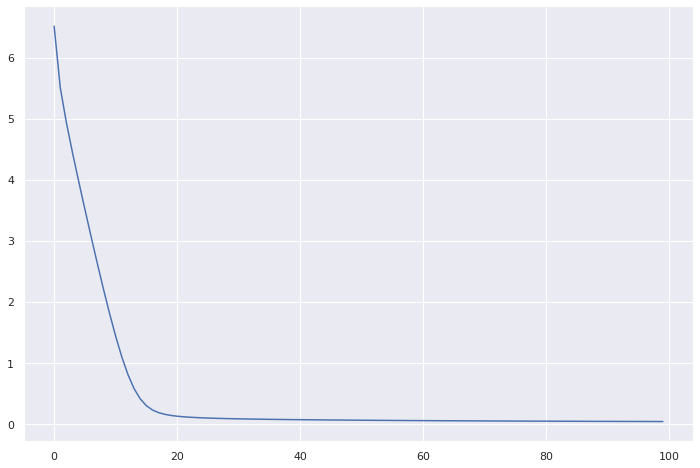

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12, 8)})

plt.plot(losses)
plt.show()

<a id="section-3-1-4-evaluate-cbow"></a>

# Apply and Evaluate the CBOW Model 

In [61]:
from lazyme import color_str

true_positive = 0
all_data = 0
# Iterate through the test sentences. 
for sent in tokenized_text_test:
    # Extract all the CBOW contexts (X) and targets (Y)
    for w2v_io in w2v_dataset._iterator(w2v_dataset.vectorize(sent)):
        # Retrieve the inputs and outputs.
        x = tensor(w2v_io['x']).to(device)
        y = tensor(w2v_io['y']).to(device)
        if -1 in x: # Skip unknown words.
            continue
            
        with torch.no_grad():
            # Remember how to get the best prediction output? 
            # Hint: https://pytorch.org/docs/stable/torch.html#torch.max
            _, prediction =  torch.max(model(x), 1)
        true_positive += int(prediction) == int(y)
        visualize_predictions(x, y, prediction, w2v_dataset.vocab, window_size=window_size)
        all_data += 1

is 		 the problem is essentially this
essentially 	 problem is particularly this :
this 		 is essentially the : if
: 		 essentially this fact if a
if 		 this : of a word
a 		 : if a word (
word 		 if a more ( or
( 		 a word ( or bigram
or 		 word ( the bigram ,
bigram 		 ( or plan , or
<unk> 		 , or by , or
<unk> 		 , or by etc .
is 		 the web in a vast
a 		 web is a vast re-
vast 		 is a role re- source
re- 		 a vast the source for
source 		 vast re- also for many
the 		 is that the association is
association 	 that the use is random
is 		 the association between random ,
random 		 association is not , arbitrary
, 		 is random it arbitrary ,
arbitrary 	 random , arbitrary , motivated
, 		 , arbitrary ______ motivated or
motivated 	 arbitrary , motivated or pre-
<unk> 		 or pre- p ( r
, 		 ( r as a ,
<unk> 		 a , distribution , p
their 		 however , all methods are
example 	 , for example , from
, 		 for example the from just
from 		 example , for just those
<unk> 		 just those the erro

In [62]:
print(torch.max(model(x), 1))
model(x)

torch.return_types.max(
values=tensor([-0.1830], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([217], device='cuda:0'))


tensor([[ -9.0954,  -8.8783, -14.1952,  ..., -14.3613, -12.3311, -12.5668]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward>)

In [63]:
print('Accuracy:', true_positive/all_data)

Accuracy: 0.25957446808510637


<a id="section-3-1-4-load-model"></a>

# Go back to the 5th Epoch

In [64]:
model_5 = CBOW(vocab_size, embd_size, window_size, hidden_size)
model_5 = torch.nn.DataParallel(model_5)
model_5.load_state_dict(torch.load('cbow_checkpoint_5.pt'))
model_5.eval()

DataParallel(
  (module): CBOW(
    (embeddings): Embedding(1303, 100)
    (linear1): Linear(in_features=400, out_features=100, bias=True)
    (linear2): Linear(in_features=100, out_features=1303, bias=True)
  )
)

In [65]:
true_positive = 0
all_data = 0
# Iterate through the test sentences. 
for sent in tokenized_text_test:
    # Extract all the CBOW contexts (X) and targets (Y)
    for w2v_io in w2v_dataset._iterator(w2v_dataset.vectorize(sent)):
        # Retrieve the inputs and outputs.
        x = tensor(w2v_io['x']).to(device)
        y = tensor(w2v_io['y']).to(device)
        
        if -1 in x: # Skip unknown words.
            continue
            
        with torch.no_grad():
            _, prediction =  torch.max(model_5(x), 1)
        true_positive += int(prediction) == int(y)
        visualize_predictions(x, y, prediction, w2v_dataset.vocab, window_size=window_size)
        all_data += 1

is 		 the problem ______ essentially this
essentially 	 problem is in this :
this 		 is essentially the : if
: 		 essentially this random if a
if 		 this : in a word
a 		 : if a word (
word 		 if a random ( or
( 		 a word ( or bigram
or 		 word ( the bigram ,
bigram 		 ( or ) , or
<unk> 		 , or by , or
<unk> 		 , or and etc .
is 		 the web in a vast
a 		 web is and vast re-
vast 		 is a in re- source
re- 		 a vast the source for
source 		 vast re- χ2 for many
the 		 is that the association is
association 	 that the data is random
is 		 the association of random ,
random 		 association is not , arbitrary
, 		 is random the arbitrary ,
arbitrary 	 random , random , motivated
, 		 , arbitrary ______ motivated or
motivated 	 arbitrary , as or pre-
<unk> 		 or pre- ) ( r
, 		 ( r and a ,
<unk> 		 a , ever , p
their 		 however , and methods are
example 	 , for random , from
, 		 for example the from just
from 		 example , and just those
<unk> 		 just those the errors that
they 		 , and a do 

In [66]:
print('Accuracy:', true_positive/all_data)
model(x).shape[1] == len(w2v_dataset.vocab)

Accuracy: 0.19574468085106383


True

#How to Handle Unknown Words? 

This is not the best way to handle unknown words, but we can simply assign an index for unknown words.

**Hint:** Ensure that you have `gensim` version >= 3.7.0 first. Otherwise this part of the code won't work.

In [67]:
!python -m pip install -U pip
!python -m pip install -U gensim>=3.7.0

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.0.2)


In [68]:
import gensim
gensim.__version__

'3.8.1'

In [69]:
vocab = Dictionary(['this is a foo bar sentence'.split()])
dict(vocab.items())

{0: 'a', 1: 'bar', 2: 'foo', 3: 'is', 4: 'sentence', 5: 'this'}

In [71]:
# See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.patch_with_special_tokens
vocab = Dictionary(['this is a foo bar sentence'.split()])

try:
    special_tokens = {'<pad>': 0, '<unk>': 1} # we define our own special tokens for missing words
    vocab.patch_with_special_tokens(special_tokens)
except: # If gensim is not 3.7.0
    pass
    
dict(vocab.items())

{0: '<pad>',
 1: '<unk>',
 2: 'foo',
 3: 'is',
 4: 'sentence',
 5: 'this',
 6: 'a',
 7: 'bar'}

#Lets Rewrite the `Word2VecText` Object

Now with the (i) unknown word patch in the vocabulary as well as (ii) `skipgram_iterator`

In [0]:
class Word2VecText(Dataset):
    def __init__(self, tokenized_texts, window_size, variant):
        """
        :param tokenized_texts: Tokenized text.
        :type tokenized_texts: list(list(str))
        """
        self.sents = tokenized_texts
        self._len = len(self.sents)
        
        # Add the unknown word patch here.
        self.vocab = Dictionary(self.sents)
        try:
            special_tokens = {'<pad>': 0, '<unk>': 1}
            self.vocab.patch_with_special_tokens(special_tokens)
        except:
            pass
        
        self.window_size = window_size
        self.variant = variant
        if variant.lower() == 'cbow':
            self._iterator = partial(self.cbow_iterator, window_size=self.window_size)
        elif variant.lower() == 'skipgram':
            self._iterator = partial(self.skipgram_iterator, window_size=self.window_size)

    def __getitem__(self, index):
        """
        The primary entry point for PyTorch datasets.
        This is were you access the specific data row you want.
        
        :param index: Index to the data point.
        :type index: int
        """
        vectorized_sent = self.vectorize(self.sents[index])
        
        return list(self._iterator(vectorized_sent))

    def __len__(self):
        return self._len
    
    def vectorize(self, tokens):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        return self.vocab.doc2idx(tokens, unknown_word_index=1)
    
    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]
    
    def cbow_iterator(self, tokens, window_size):
        n = window_size * 2 + 1
        for window in per_window(tokens, n):
            target = window.pop(window_size)
            yield {'x': window, 'y': target}   # X = window ; Y = target. 
            
    def skipgram_iterator(self, tokens, window_size):
        n = window_size * 2 + 1 
        for i, window in enumerate(per_window(tokens, n)):
            focus = window.pop(window_size)
            # Generate positive samples.
            for context_word in window:
                yield {'x': (focus, context_word), 'y':1}
            # Generate negative samples.
            for _ in range(n-1):
                leftovers = tokens[:i] + tokens[i+n:]
                if leftovers:
                    yield {'x': (focus, random.choice(leftovers)), 'y':0}

<a id="section-3-1-5"></a>

# Lets try the skipgram task

In [0]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embd_size):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
    
    def forward(self, focus, context):
        embed_focus = self.embeddings(focus).view((1, -1))
        embed_context = self.embeddings(context).view((1, -1))
        # See https://pytorch.org/docs/stable/torch.html#torch.t
        score = torch.mm(embed_focus, torch.t(embed_context))
        log_probs = F.logsigmoid(score)
        return log_probs

<a id="section-3-1-5-foward"></a>

# Take a closer look at what's in the `forward()`

In [0]:
xx1 = torch.rand(1,20)
xx2 = torch.rand(1,20)

xx1_numpy = xx1.detach().numpy()
xx2_numpy = xx2.detach().numpy()

In [75]:
print(xx1_numpy.shape)
print(xx2_numpy.T.shape)
print(np.dot(xx1_numpy, xx2_numpy.T))

print(xx1.shape)
print(torch.t(xx2).shape) 
print(torch.mm(xx1, torch.t(xx2)))

(1, 20)
(20, 1)
[[6.148223]]
torch.Size([1, 20])
torch.Size([20, 1])
tensor([[6.1482]])


<a id="section-3-1-5-train"></a>

# Train a Skipgram model (for real)

In [0]:
#Utility code to monitor the GPU usage
import subprocess

def get_gpu_memory_map():
    """Get the current gpu usage.

    Returns
    -------
    usage: dict
        Keys are device ids as integers.
        Values are memory usage as integers in MB.
    """
    result = subprocess.check_output(
        [
            'nvidia-smi', '--query-gpu=memory.used',
            '--format=csv,nounits,noheader'
        ], encoding='utf-8')
    # Convert lines into a dictionary
    gpu_memory = [int(x) for x in result.strip().split('\n')]
    gpu_memory_map = dict(zip(range(len(gpu_memory)), gpu_memory))
    return gpu_memory_map

In [83]:
embd_size = 100
learning_rate = 0.03
hidden_size = 30 #To reduce training time changing 300 to 30
window_size = 3

# Initialize the dataset.
w2v_dataset = Word2VecText(tokenized_text_train, window_size=3, variant='skipgram')
vocab_size = len(w2v_dataset.vocab)

criterion = nn.MSELoss()
# Use the Skipgram object
model = SkipGram(vocab_size, embd_size,).to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

losses = []

#model = nn.DataParallel(model) #You can easily run your operations on multiple GPUs by making your model run parallelly using DataParallel
#refer - https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html
num_epochs = 100
for _e in tqdm(range(num_epochs)):
    epcoh_loss = 0
    for sent_idx in range(w2v_dataset._len):
        for w2v_io in w2v_dataset[sent_idx]:
            # Retrieve the inputs and outputs.
            x1, x2 = w2v_io['x']
            x1, x2 = tensor(x1).to(device), tensor(x2).to(device)
            y = autograd.Variable(tensor(w2v_io['y'], dtype=torch.float)).to(device)
            # Zero gradient.
            model.zero_grad()
            # Calculate the log probability of the context embeddings.
            logprobs = model(x1, x2)
            # This unsqueeze thing is really a feature/bug... -_-
            loss = criterion(logprobs, y.unsqueeze(0)) 
            loss.backward()
            optimizer.step()
            epcoh_loss += float(loss)
    #print('GPU Memory ->', torch.cuda.get_device_properties(device).total_memory)
    #print('GPU Space ->', get_gpu_memory_map())
    torch.save(model.state_dict(), 'skipgram_checkpoint_{}.pt'.format(_e))
    losses.append(epcoh_loss)





  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)




  1%|          | 1/100 [00:36<1:00:37, 36.75s/it]

GPU Space -> {0: 811}


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)




  2%|▏         | 2/100 [01:13<59:53, 36.67s/it]  

GPU Space -> {0: 811}


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: ignored

<a id="section-3-1-5-evaluate"></a>

# Evaluate the model on the skipgram task

In [0]:
true_positive = 0
all_data = 0
# Iterate through the test sentences. 
for sent in tokenized_text_test:
    # Extract all the CBOW contexts (X) and targets (Y)
    for w2v_io in w2v_dataset._iterator(w2v_dataset.vectorize(sent)):
        model.zero_grad()
        # Retrieve the inputs and outputs.
        x1, x2 = w2v_io['x']
        x1, x2 = tensor(x1).to(device), tensor(x2).to(device) #make sure you are running on GPU or CPU.
        y = w2v_io['y']
        _, prediction =  torch.max(model(x1, x2), 1)    
        true_positive += int(prediction) == int(y)
        all_data += 1

In [86]:
print('Accuracy:', true_positive/all_data)

Accuracy: 0.5
